In [1]:
import numpy as np
import pandas as pd
import itertools
import os, stat, time
from os.path import dirname as up
import random
import shutil
import glob
from PIL import Image
import matplotlib.pyplot as plt

In [26]:
# Plot Settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [2]:
from glob import glob
data = glob('./Images/**/*.png', recursive=True)

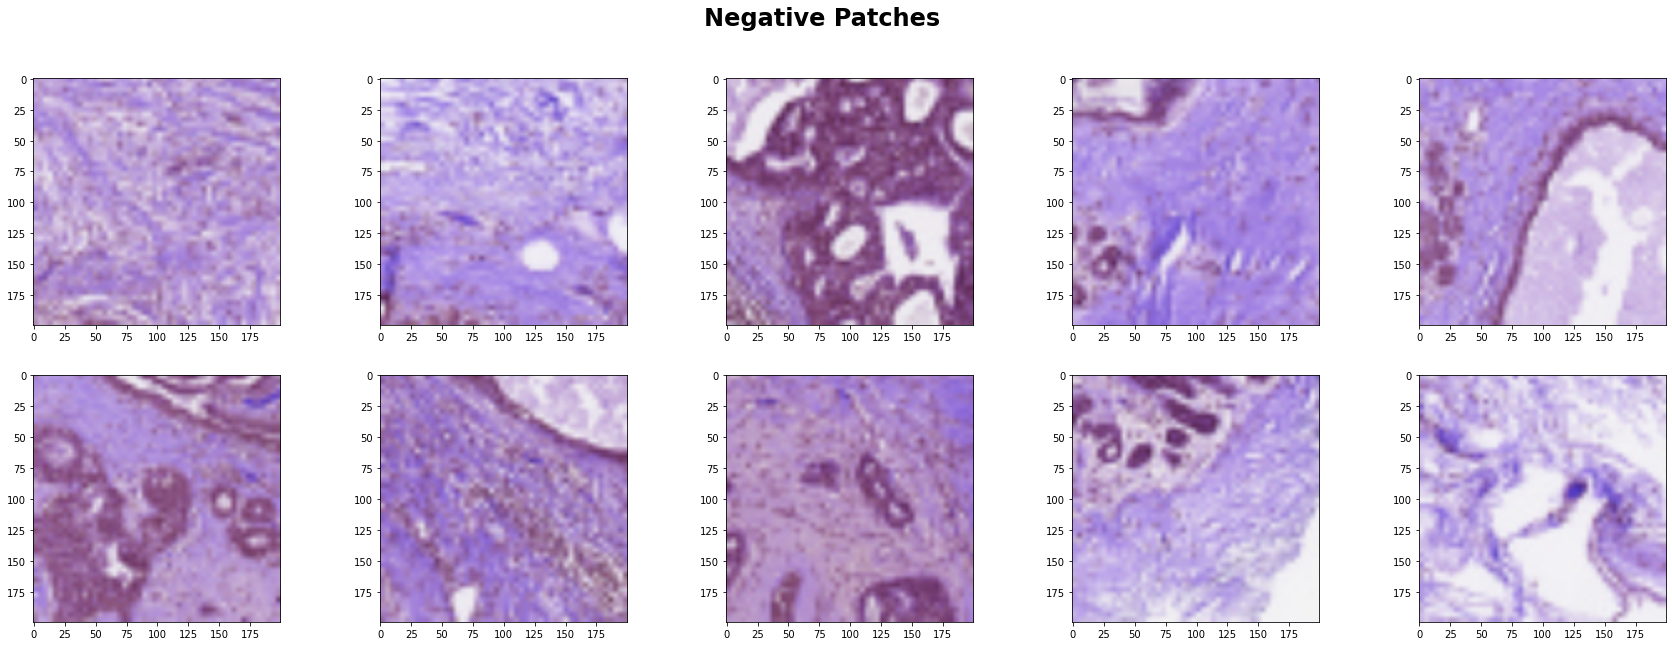

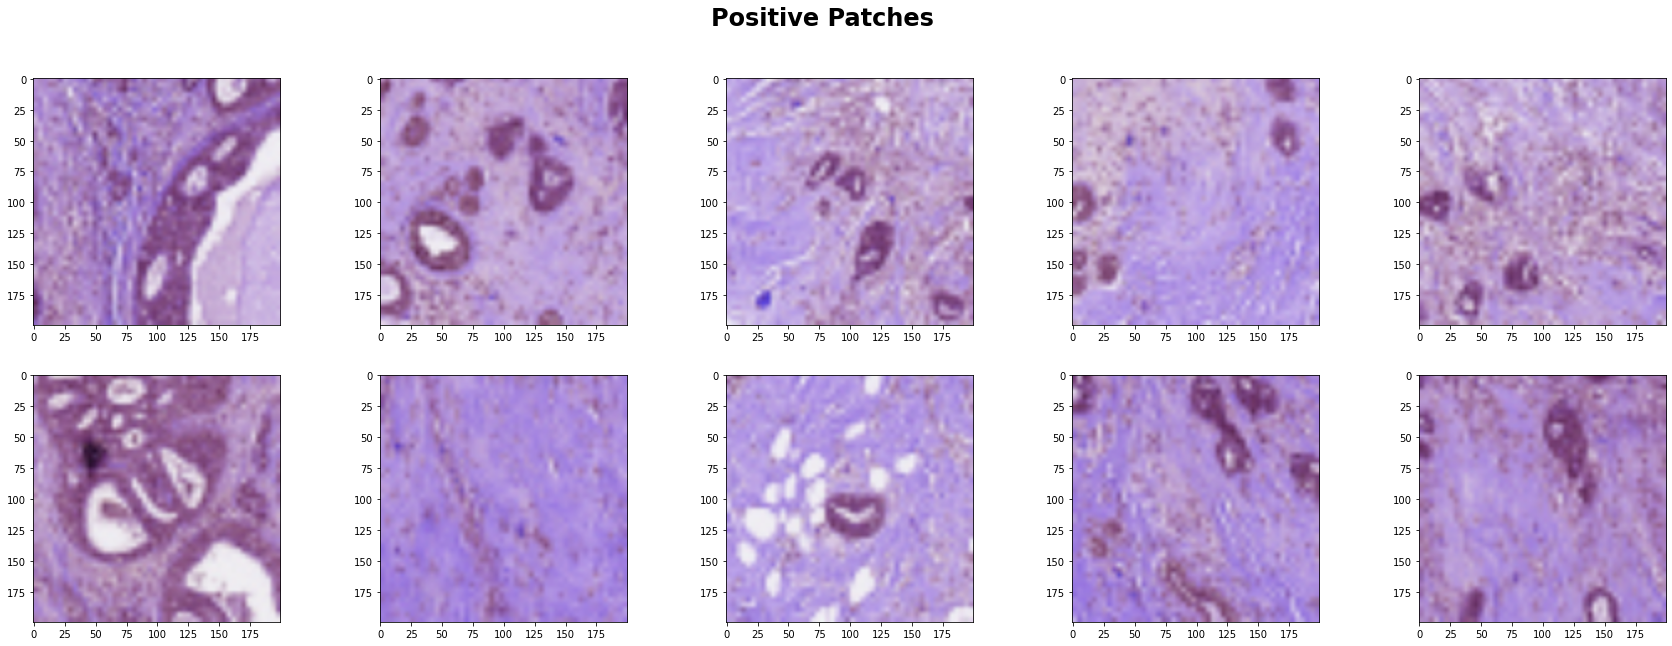

In [3]:
import cv2

# Negative Patches
fig, ax = plt.subplots(2, 5,figsize = (30,10))

n_plots = 0
for i in data[:1000]:

    if (i[-5]=='0'):
        img = cv2.imread(i)
        img_temp = cv2.resize(img,(200,200))
        ax[n_plots//5, n_plots%5].imshow(img_temp, cmap='binary')
        ax[n_plots//5, n_plots%5].grid(False)
        n_plots += 1
        
    if (n_plots==10): 
        break

fig.suptitle('Negative Patches', fontsize=24, fontweight='bold')
plt.show()

# Positive Patches
fig, ax = plt.subplots(2, 5,figsize = (30,10))

n_plots = 0

for i in data[:2000]:

    if (i[-5]=='1'):
        img = cv2.imread(i)
        img_temp = cv2.resize(img,(200,200))
        ax[n_plots//5, n_plots%5].imshow(img_temp, cmap='binary')
        ax[n_plots//5, n_plots%5].grid(False)
        n_plots += 1
        
    if (n_plots==10): 
        break

fig.suptitle('Positive Patches', fontsize=24, fontweight='bold')
plt.show()

In [4]:
images=[]
labels=[]
# evt = 0
for img_name in data[:15000]:
    if img_name.endswith('.png'):
        label = img_name[-5]
        img = cv2.imread(img_name)
        img_temp = cv2.resize(img,(224,224))
        images.append(img_temp.astype(np.float32))
        labels.append(int(label))
#         evt += 1
#         if (evt%1000==0):
#             print (evt)

# x = np.stack(images)

full_data_set = []
for i in range(len(labels)):
    full_data_set.append([images[i], labels[i]])
    
random.shuffle(full_data_set)

In [5]:
print ('Number of images with label 1:', np.sum(labels))

Number of images with label 1: 4060


In [6]:
data_set = full_data_set[:10000]

In [7]:
np.array(data_set)[0:16, 1]

/tmp/ipykernel_100/422483837.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(data_set)[0:16, 1]


array([0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1], dtype=object)

In [8]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [9]:
torch.__version__

'1.9.0+cu111'

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [11]:
train_set, val_set = torch.utils.data.random_split(data_set, [int(len(data_set)*0.8), int(len(data_set)*0.2)], 
                                                   generator=torch.Generator().manual_seed(42))

image_datasets = {
    'train': train_set,
    'validation': val_set
}

In [12]:
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

dataloaders = {
    'train': train_dataloader,
    'validation': val_dataloader
}

In [13]:
model = models.googlenet(pretrained=True).to(device)

model.fc = nn.Sequential(
               nn.Linear(1024, 64),
               nn.Linear(64, 2),
               nn.Softmax(dim=1)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.000001, betas=(0.9, 0.999), weight_decay=0.5e-3, eps=1e-08, amsgrad=False)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /tmp/xdg-cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [14]:
def train_model(model, criterion, optimizer, num_epochs=3):
    
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    
    for epoch in range(num_epochs):
        
        print()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 50)

        for phase in ['train', 'validation']:
            
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(torch.transpose(torch.transpose(inputs, 1, 3), 2, 3))
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # print (outputs)
                _, preds = torch.max(outputs, 1)
                # print ('Outputs:', outputs)
                # print ('Preds:', preds)
                # print ('Labels:', labels.data)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # print ('Running corrects:', running_corrects)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects / len(image_datasets[phase])
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    stats = {'train loss': train_loss,
             'train accuracy': train_acc,
             'validation loss': val_loss,
             'validation accuracy': val_acc}
    
    return model, stats

In [15]:
model_trained, stats_trained = train_model(model, criterion, optimizer, num_epochs=50)


Epoch 1/50
--------------------------------------------------


/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train loss: 0.6729, acc: 0.6863
validation loss: 0.6568, acc: 0.7765

Epoch 2/50
--------------------------------------------------
train loss: 0.6447, acc: 0.7786
validation loss: 0.6313, acc: 0.7860

Epoch 3/50
--------------------------------------------------
train loss: 0.6189, acc: 0.7856
validation loss: 0.6082, acc: 0.7845

Epoch 4/50
--------------------------------------------------
train loss: 0.5969, acc: 0.7921
validation loss: 0.5880, acc: 0.7930

Epoch 5/50
--------------------------------------------------
train loss: 0.5777, acc: 0.8039
validation loss: 0.5704, acc: 0.8005

Epoch 6/50
--------------------------------------------------
train loss: 0.5609, acc: 0.8203
validation loss: 0.5546, acc: 0.8145

Epoch 7/50
--------------------------------------------------
train loss: 0.5463, acc: 0.8343
validation loss: 0.5409, acc: 0.8270

Epoch 8/50
--------------------------------------------------
train loss: 0.5337, acc: 0.8395
validation loss: 0.5305, acc: 0.8395

Epoch 

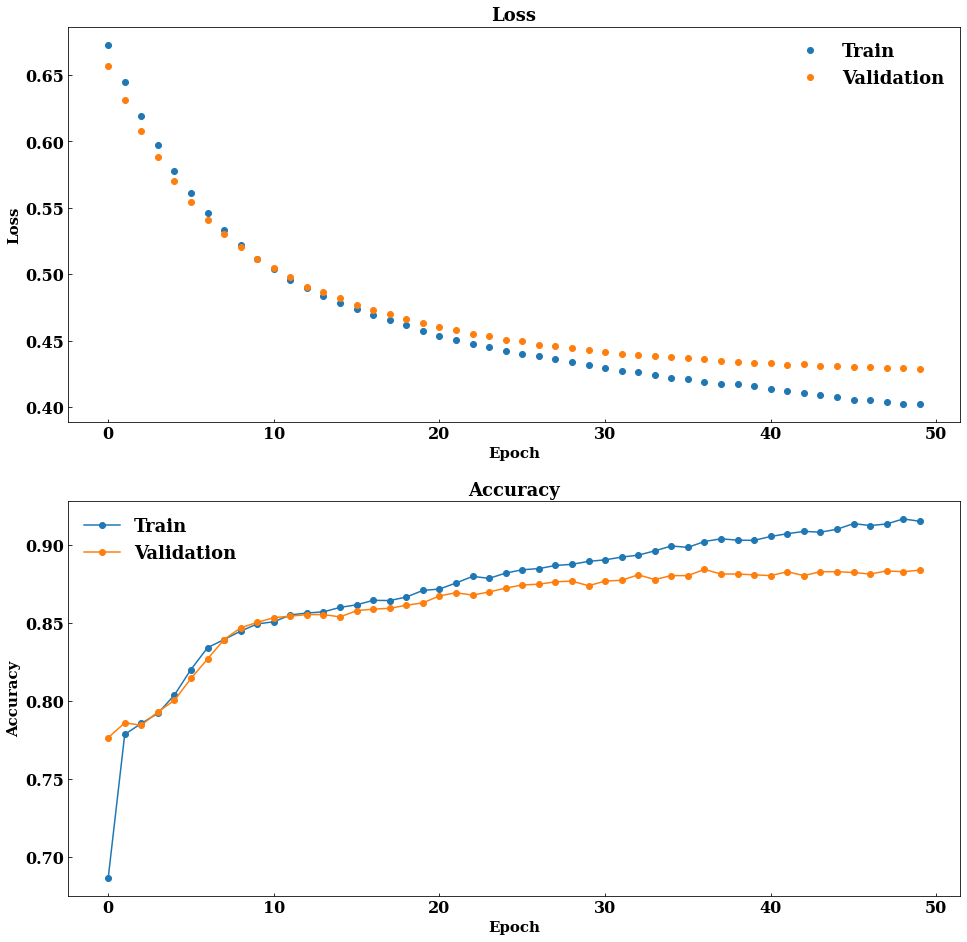

In [35]:
# Visualize training loss and train / val accuracy
fig = plt.figure(figsize=(16,16))
plt.subplot(2, 1, 1)
plt.title('Loss', fontweight='bold', fontsize=18)
plt.plot(stats_trained['train loss'], 'o', label='Train')
plt.plot(stats_trained['validation loss'], 'o', label='Validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best', prop={'size':18}, frameon=False)

plt.subplot(2, 1, 2)
plt.title('Accuracy', fontweight='bold', fontsize=18)
plt.plot(stats_trained['train accuracy'], '-o', label='Train')
plt.plot(stats_trained['validation accuracy'], '-o', label='Validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best', prop={'size':18}, frameon=False)
# plt.gcf().set_size_inches(15, 12)
plt.savefig('./Fig/GoogleNet_result_v2.png')
plt.show()

In [17]:
test_set = full_data_set[10000:11000]
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

running_corrects = 0
for inputs, labels in test_dataloader:
    
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model_trained(torch.transpose(torch.transpose(inputs, 1, 3), 2, 3))
    # print (outputs)
    
    _, preds = torch.max(outputs, 1)
    # print ('Predictions:', preds)
    running_corrects += torch.sum(preds == labels.data)
    
print ('Test Accuracy:', running_corrects/len(test_set))

Test Accuracy: tensor(0.8850, device='cuda:0')


In [18]:
torch.save(model_trained.state_dict(), './Models/googlenet_trained.pth')

In [19]:
model_load = models.googlenet(pretrained=True).to(device)
model_load.load_state_dict(torch.load('./Models/googlenet_trained.pth'))
model_load.eval()

RuntimeError: Error(s) in loading state_dict for GoogLeNet:
	Missing key(s) in state_dict: "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "fc.0.weight", "fc.0.bias", "fc.1.weight", "fc.1.bias". 